In [19]:
import numpy as np 
import scipy as sp 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

from datetime import date, datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (50, 20)})  

from cryptocompare import get_daily_trade_hist
from indicators import *

import requests

import plot

In [2]:
btc = get_daily_trade_hist('BTC', all_data=True)

In [45]:
periods = [1, 3, 7, 14]

for days in periods:
    col = 'returns_{}d'.format(days)
    btc[col] = btc.close.pct_change(days)

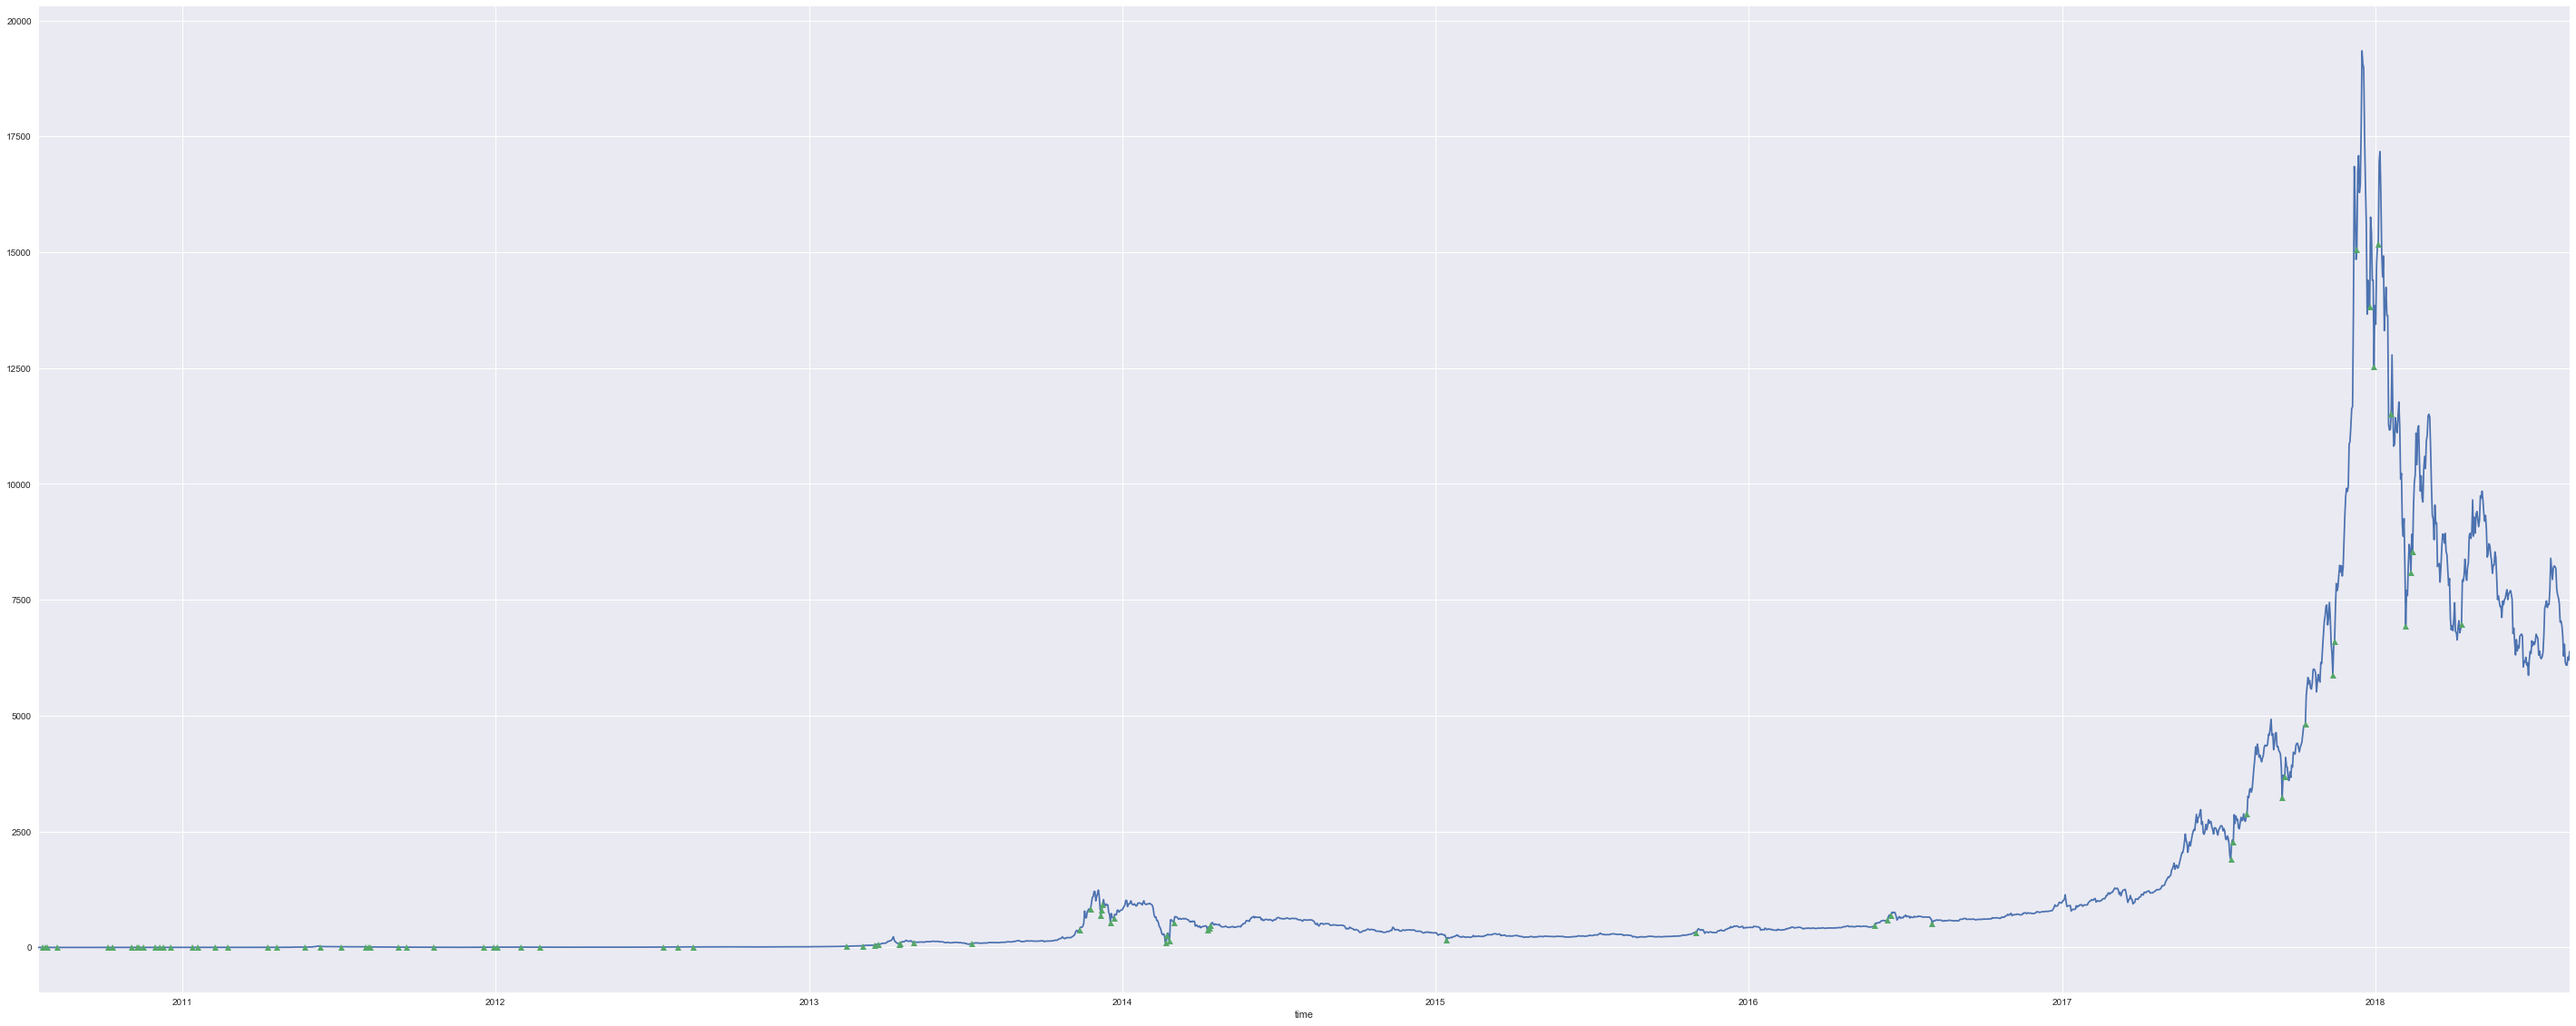

In [57]:
btc.close.plot()
ymin, ymax = ax.get_ybound()

base_scenarios = {
    'price_slowly_falls_and_reverses': None,
    'price_quickly_falls_and_rebounds': None
}
condition = (
    #(btc.returns_14d<0)
    ((btc.returns_7d<0.10)|(btc.returns_3d<.05))
    &(btc.returns_1d.shift(-1)>.1)
    #&(((btc.returns_1d>0).diff()==1))
)
btc[condition].close.plot(marker='^', ls='')
#ax.plot(btc.index, )
#ax.fill_between(btc.index, ymin, ymax, where=condition, color='red', alpha=0.3)

In [27]:
btc[condition]

,close,high,low,open,volumefrom,volumeto,returns_1d,returns_7d,returns_14d
time,,,,,,,,,
2014-02-22,255.59,290.59,96.72,111.56,72170.05,11838225.02,1.291054,-0.311208,-0.606045


In [24]:
ax.get_ybound()

(-967.22251449999999, 20312.7620245)

In [79]:
# https://stackoverflow.com/questions/8587047/support-resistance-algorithm-technical-analysis/8590007#8590007
def supres(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """
    from scipy.signal import savgol_filter as smooth

    # converting n to a nearest even number
    if n % 2 != 0:
        n += 1

    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n + 1), 3)

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])

    resistance = []
    support = []

    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:int(i + n)]
        first = arr_sl[:int(n / 2)]  # first half
        last = arr_sl[int(n / 2):]  # second half

        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n / 2)) and (r_2 == (n / 2)):
            resistance.append(ltp[i + int((n / 2) - 1)])

        # local minima detection
        if (s_1 == (n / 2)) and (s_2 == (n / 2)):
            support.append(ltp[i + int((n / 2) - 1)])

    return support, resistance

In [93]:
sup, res = supres(btc.close, 7)

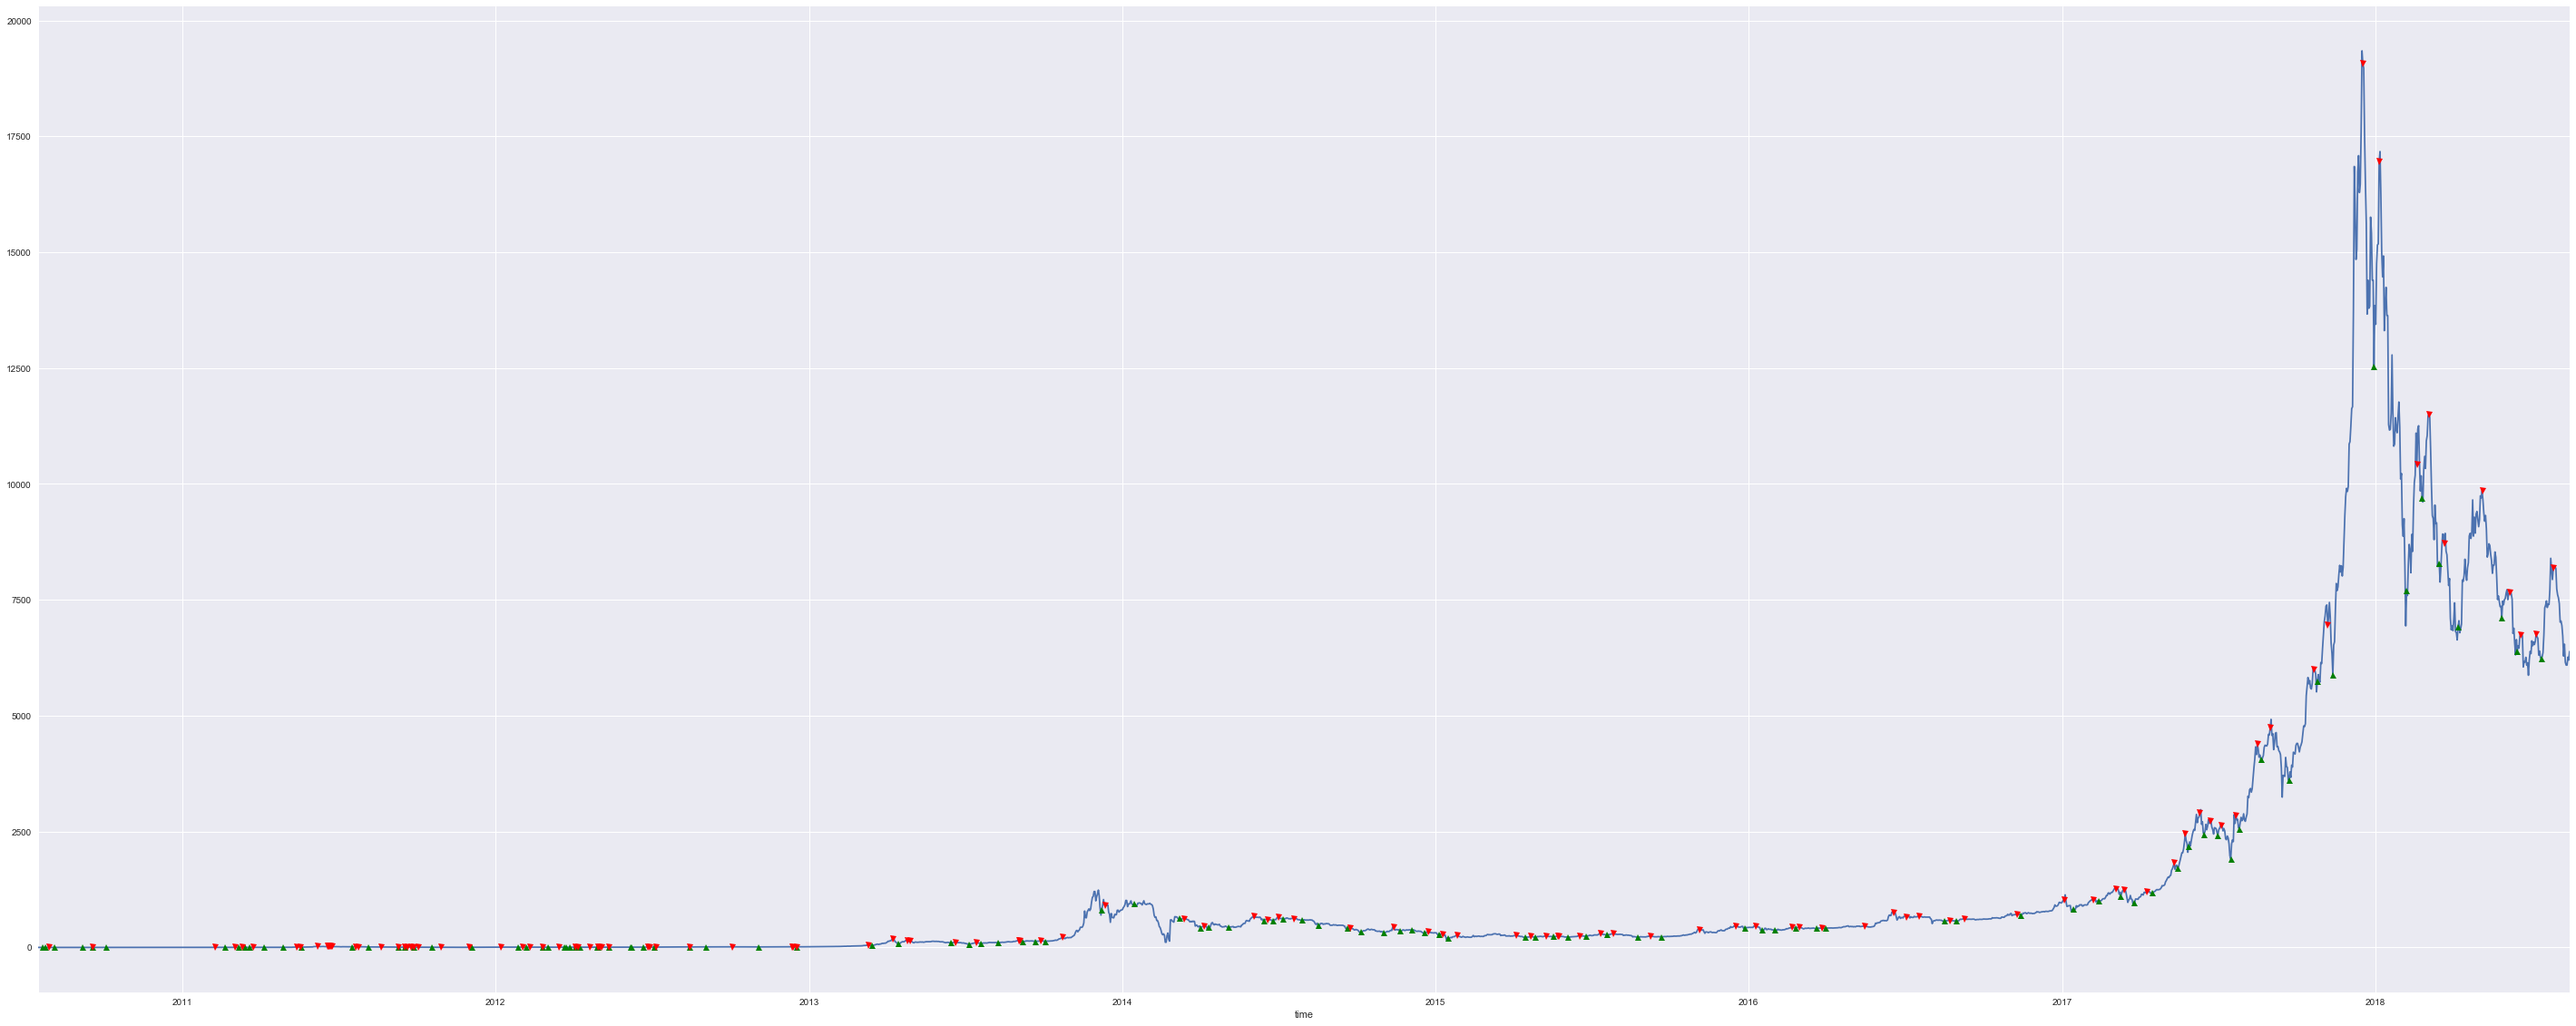

In [94]:
btc.close.plot()
btc[btc.close.isin(sup)].close.plot(marker='^', ls='', color='g')
btc[btc.close.isin(res)].close.plot(marker='v', ls='', color='r')

In [100]:
data = btc.copy()#.reset_index()
data.head()

,close,high,low,open,volumefrom,volumeto,returns_1d,returns_7d,returns_14d,returns_3d
time,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,NaN,NaN,NaN,NaN
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900,0.733791,NaN,NaN,NaN
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600,-0.058714,NaN,NaN,NaN
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900,-0.075000,NaN,NaN,0.509594
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600,0.059807,NaN,NaN,-0.077237


In [102]:

data['WeekResist'] = 0
data['WeekSupport'] = 0
data['MonthResist'] = 0
data['MonthSupport'] = 0
data['YearResist'] = 0
data['YearSupport'] = 0
data['HistoryResist'] = 0
data['HistorySupport'] = 0

for day in range(0,len(data)):
    idx = data.index[day-1]
    idx_week =  data.index[day] - pd.DateOffset(weeks=1)
    weekresist = data.ix[idx_week:idx,'high'].max()
    data.ix[day,'WeekResist'] = weekresist
    weeksupport = data.ix[idx_week:idx,'low'].min()
    data.ix[day,'WeekSupport'] = weeksupport

    idx_month =  data.index[day] - pd.DateOffset(months=1)
    monthresist = data.ix[idx_month:idx,'high'].max()
    data.ix[day,'MonthResist'] = monthresist         
    monthsupport = data.ix[idx_month:idx,'low'].min()
    data.ix[day,'MonthSupport'] = monthsupport         

    idx_year =  data.index[day] - pd.DateOffset(years=1)
    yearresist = data.ix[idx_year:idx,'high'].max()
    data.ix[day,'YearResist'] = yearresist        
    yearsupport = data.ix[idx_year:idx,'low'].min()
    data.ix[day,'YearSupport'] = yearsupport        

    allresist = data.ix[:idx,'high'].max()
    data.ix[day,'HistoryResist'] = allresist
    allsupport = data.ix[:idx,'low'].min()
    data.ix[day,'HistorySupport'] = allsupport

SyntaxError: 'return' outside function (<ipython-input-102-6f0e4f7c388c>, line 36)

In [135]:
section.MonthSupport

time
2010-07-17     0.01000
2010-07-18     0.04951
2010-07-19     0.04951
2010-07-20     0.04951
2010-07-21     0.04951
2010-07-22     0.04951
2010-07-23     0.04951
2010-07-24     0.04951
2010-07-25     0.04951
2010-07-26     0.04951
2010-07-27     0.04951
2010-07-28     0.04951
2010-07-29     0.04951
2010-07-30     0.04951
2010-07-31     0.04951
2010-08-01     0.04951
2010-08-02     0.04951
2010-08-03     0.04951
2010-08-04     0.04951
2010-08-05     0.04951
2010-08-06     0.04951
2010-08-07     0.04951
2010-08-08     0.04951
2010-08-09     0.04951
2010-08-10     0.04951
2010-08-11     0.04951
2010-08-12     0.04951
2010-08-13     0.04951
2010-08-14     0.04951
2010-08-15     0.04951
2010-08-16     0.04951
2010-08-17     0.04951
2010-08-18     0.05000
2010-08-19     0.05000
2010-08-20     0.05000
2010-08-21     0.05000
2010-08-22     0.05000
2010-08-23     0.05000
2010-08-24     0.05000
2010-08-25     0.05000
2010-08-26     0.05000
2010-08-27     0.05300
2010-08-28     0.05400
2010-0

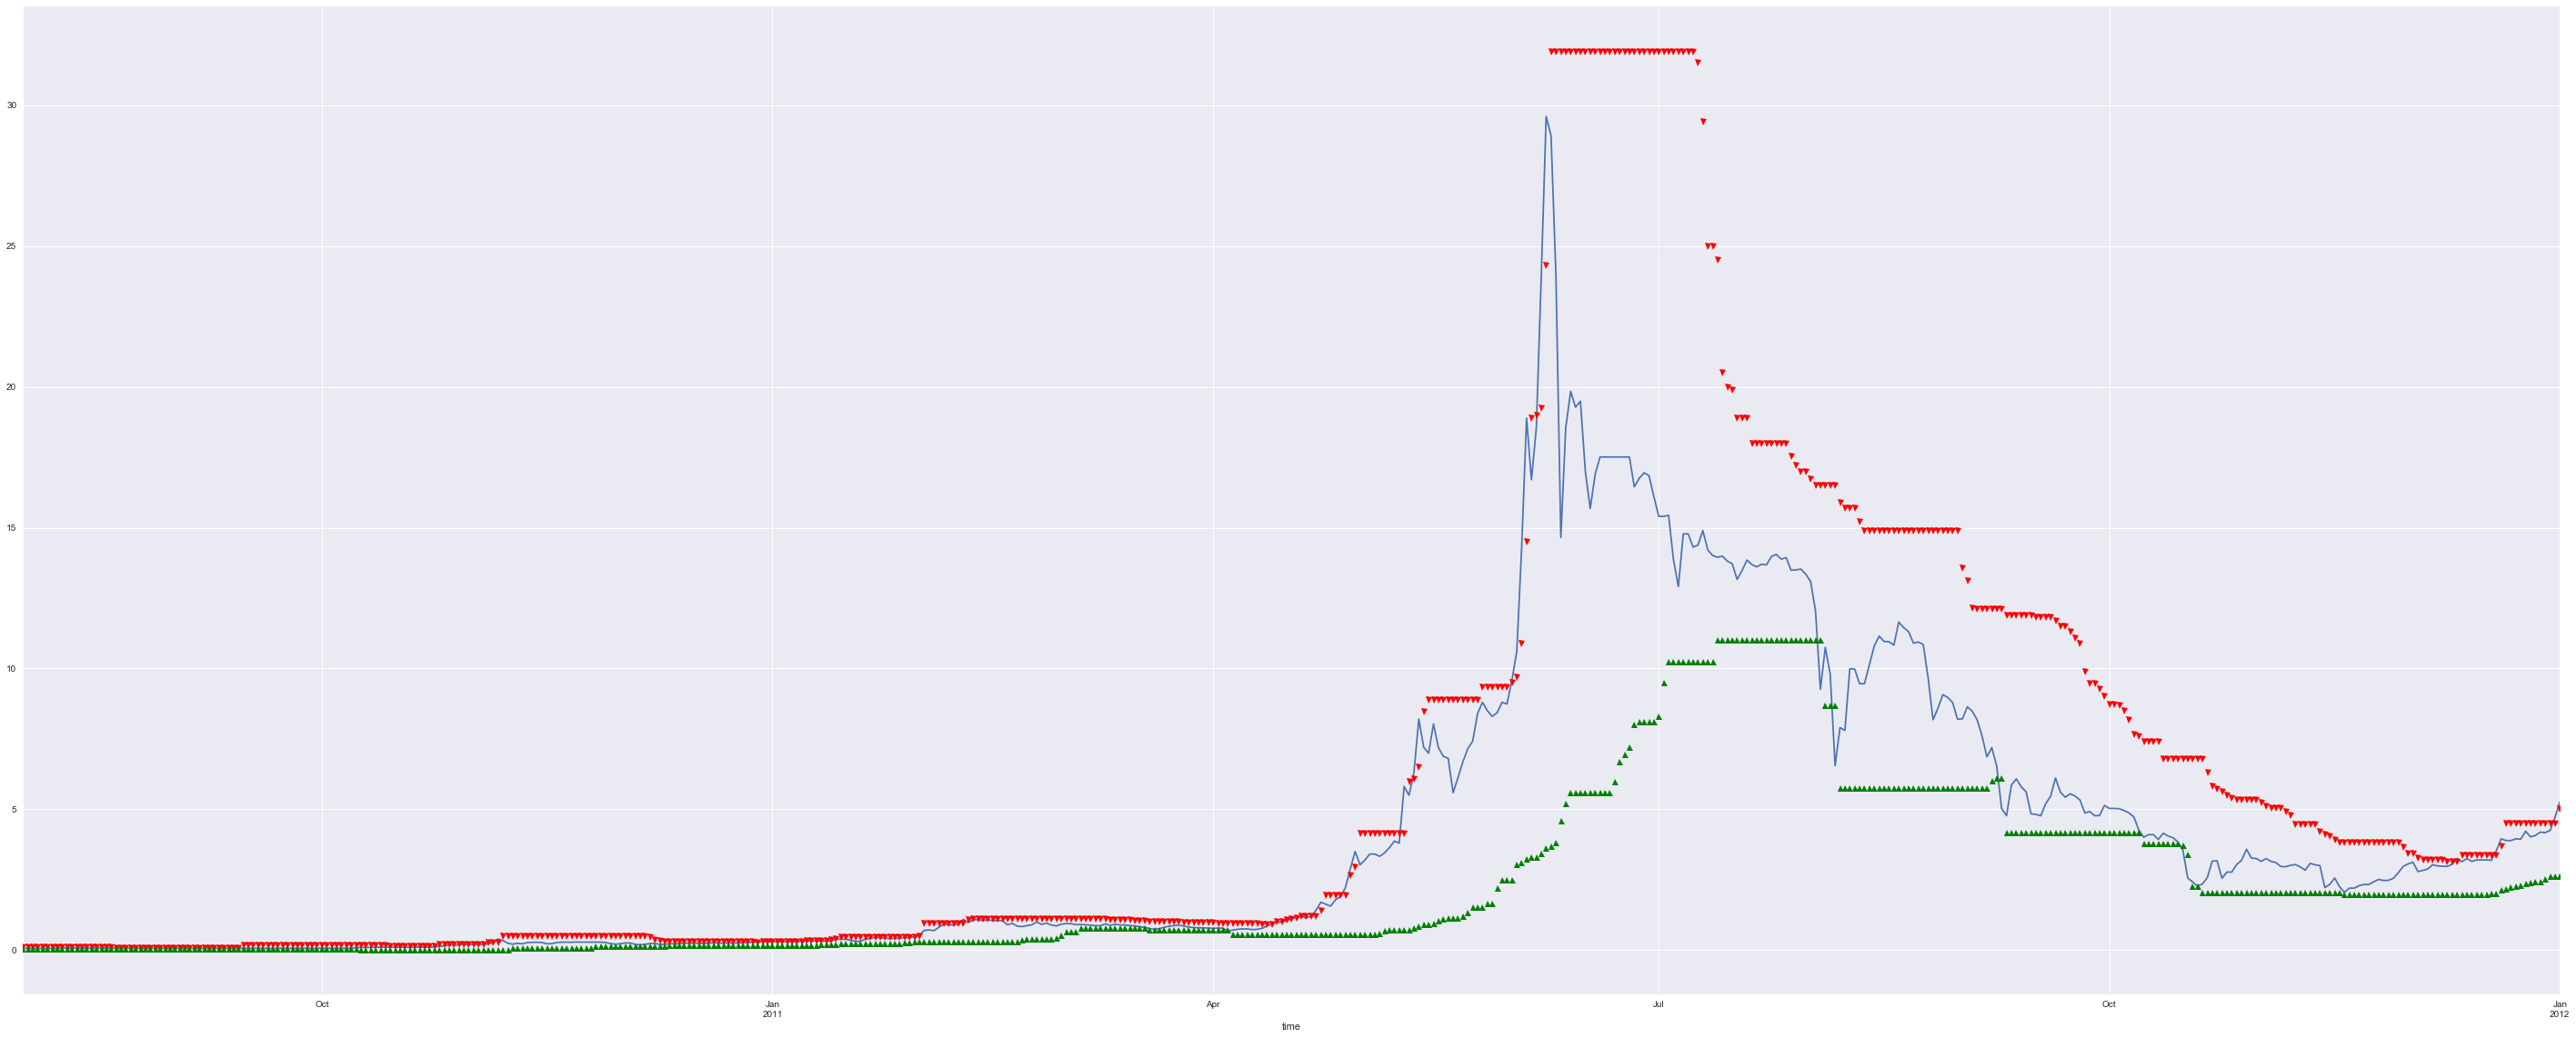

In [136]:
start = datetime(2010,8,1)
end = datetime(2012,1,1)
section = data[start:end]
section.close.plot()
section.MonthResist.plot(marker='v', ls='', color='r')
section.MonthSupport.plot(marker='^', ls='', color='g')

In [124]:
# https://github.com/steveyx/SupportResistTradingTestUsingPandas/blob/master/resist_support_study.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader.data as web
import datetime as dt
import os
from   matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates


start = '20100101'
end = '20170101'
#start = datetime.datetime(2010, 1, 1)
#end = datetime.datetime(2017, 1, 1)


def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        ax = plt.subplot(1, 1, 1)
    idx_name = df.index.name
    dat = df.reset_index()[[idx_name, "open", "high", "low", "close"]]
    dat[df.index.name] = dat[df.index.name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    ax.autoscale_view()
    plt.xticks(rotation=30)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha = 0.75)
    ax.set_title("History price chart",fontsize=28)
    ax.set_xlabel(idx_name,fontsize=20)
    ax.set_ylabel("Price",fontsize=20)
    ax.set_ylim(df.low.min()*0.9,df.high.max()*1.05)
    df.WeekResist.plot(linestyle='None',marker="_", markeredgecolor ='red', markersize=20)
    df.WeekSupport.plot(linestyle='None',marker="_", markeredgecolor ='blue', markersize=20)
    df.MonthResist.plot(linestyle='None',marker="_", markeredgecolor ='purple', markersize=20)
    df.MonthSupport.plot(linestyle='None',marker="_", markeredgecolor ='orange', markersize=20)
    df.TradeEntry.plot(linestyle='None',marker="^", markeredgecolor ='orange',markerfacecolor=None, markersize=20)
    ax.grid()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1)
    #plt.show()
    return ax


def loadData(symbol):
#    symbol ="F"
    filename = symbol + start+'_' + end+'.csv'
    loc = 'data\\'+ filename
    if not os.path.exists(loc):
#        data  = web.DataReader(symbol, 'google', start, end)
        data = quandl.get("WIKI/"+symbol, start_date=start, end_date=end)
        #[['Adj. close']].rename(columns={'Adj. close':stk})
        data.to_csv(loc)
    else:
        data =  pd.read_csv(loc,header=0, index_col='Date',parse_dates=['Date'])
    return data

def findSRs(data):
    
     #    WeeklySR
     #    MonthlySR
     #    YearlySR
     #    AllSR
     s = data.index.get_loc('20120101',"bfill")
     data['WeekResist'] = 0
     data['WeekSupport'] = 0
     data['MonthResist'] = 0
     data['MonthSupport'] = 0
     data['YearResist'] = 0
     data['YearSupport'] = 0
     data['HistoryResist'] = 0
     data['HistorySupport'] = 0
     
     for day in range(s,len(data)):
         idx = data.index[day-1]
         idx_week =  data.index[day] - pd.DateOffset(weeks=1)
         weekresist = data.ix[idx_week:idx,'high'].max()
         data.ix[day,'WeekResist'] = weekresist
         weeksupport = data.ix[idx_week:idx,'low'].min()
         data.ix[day,'WeekSupport'] = weeksupport
         
         idx_month =  data.index[day] - pd.DateOffset(months=1)
         monthresist = data.ix[idx_month:idx,'high'].max()
         data.ix[day,'MonthResist'] = monthresist         
         monthsupport = data.ix[idx_month:idx,'low'].min()
         data.ix[day,'MonthSupport'] = monthsupport         
         
         idx_year =  data.index[day] - pd.DateOffset(years=1)
         yearresist = data.ix[idx_year:idx,'high'].max()
         data.ix[day,'YearResist'] = yearresist        
         yearsupport = data.ix[idx_year:idx,'low'].min()
         data.ix[day,'YearSupport'] = yearsupport        

         allresist = data.ix[:idx,'high'].max()
         data.ix[day,'HistoryResist'] = allresist
         allsupport = data.ix[:idx,'low'].min()
         data.ix[day,'HistorySupport'] = allsupport
         
     return data

def tradeSRs(data):
    sdate = dt.datetime(2012, 1, 1)
    s = data.index.get_loc(sdate,"bfill")
    cond1 = data.index > sdate
    cond2 = data.close > data.WeekResist
    cond3 = data.close.shift(1) < data.WeekResist
    cond4 = data.MonthResist > data.WeekResist * 1.03
    all_conds = (cond1) & (cond2) & (cond3) & (cond4)
    data['TradeEntry'] = 0
    data.ix[all_conds, 'TradeEntry'] = data.ix[all_conds, 'close'] 

    TakeProfit = 0.02
    #     StopLoss = -0.02
    data['TradeExit'] = 0
    data['TradeExitDate'] = 0
    for day in range(s,len(data)):
        #         idx = data.index[day]
        if data.ix[day, 'TradeEntry'] > 0:
            for daynext in range(day,day+5):
                if daynext>= len(data):
                    break
                profit_pct = data.ix[daynext, 'high'] / data.ix[day, 'TradeEntry'] -1
                if profit_pct > TakeProfit:
                    data.ix[day, 'TradeExit'] = data.ix[day, 'TradeEntry'] * (1+TakeProfit)
                    data.ix[day, 'TradeExitDate'] = data.index[daynext]
                    break
                else:
                    data.ix[day, 'TradeExit'] = data.ix[daynext, 'close']
                    data.ix[day, 'TradeExitDate'] = data.index[daynext]

    return data

def tradePerformance(data):
    totaltrades = len(data[data['TradeEntry']>0])
    wintrades = len(data[data['TradeExit'] - data['TradeEntry']>0])
    losetrades = len(data[data['TradeExit'] - data['TradeEntry']<0])
    winpct = float (wintrades / totaltrades)
    
    
    data['WinPct'] = 0
    t_ind = data['TradeExit']>0
    data.ix[t_ind, 'WinPct'] = data.ix[t_ind, 'TradeExit'] /  data.ix[t_ind, 'TradeEntry'] - 1
    finalblance =  data.ix[t_ind, 'WinPct'].sum() + 1
    
    print("total number of trades: {}".format(totaltrades))
    print("number of winning trades: {}".format(wintrades))
    print("number of losing trades: {}".format(losetrades))
    print("winning trade pencentage: {:.2f}%".format(winpct*100))
    print("final balance: {:.2f}% (initial 100%)".format(finalblance*100))
    
    result =[totaltrades,wintrades,losetrades,winpct*100,finalblance*100]
    return (data,result)


"""
    
if __name__ == "__main__":
    symbol_list = ["CELG", "CF", "CI", "CSCO", "C", "KO", "DAL", "EFX"]
    symbol_list = ["ADM", "T", "AVY", "BAX", "BLK", "BA", "BSX", "COG"]
    symbol_list = ["AAPL","IBM","YHOO", "STX", "MSFT", "GOOGL", "HP" , "FB"]
    symbol_list = ["EQR", "ACN", "EBAY", "AVGO", "MMM", "ADBE", "AIG", "AON"]
    TradeResults = pd.DataFrame(columns = ['Symbol','TotalTrades','Win','Lose','WinPnt(%)','Balance(%)'])
    for sym in symbol_list:
        data_sym = loadData(sym)
        data_sym = findSRs(data_sym)
        data_sym = tradeSRs(data_sym)
        data_sym, res = tradePerformance(data_sym)
        TradeResults = TradeResults.append({
              'Symbol':sym,
              'TotalTrades':res[0],
              'Win':res[1],
              'Lose':res[2],
              'WinPnt(%)':res[3],
              'Balance(%)':res[4]},ignore_index=True
              )
    TradeResults['TotalTrades'] =  TradeResults['TotalTrades'].astype(int)
    TradeResults['Win'] =  TradeResults['Win'].astype(int)
    TradeResults['Lose'] =  TradeResults['Lose'].astype(int)
    TradeResults['WinPnt(%)'] =  TradeResults['WinPnt(%)'].round(2)
    TradeResults['Balance(%)'] =  TradeResults['Balance(%)'].round(2)
    TradeResults = TradeResults.set_index(['Symbol'])
    print(TradeResults)
    #ax = plot_candlestick(AAPL)
"""


'\n    \nif __name__ == "__main__":\n    symbol_list = ["CELG", "CF", "CI", "CSCO", "C", "KO", "DAL", "EFX"]\n    symbol_list = ["ADM", "T", "AVY", "BAX", "BLK", "BA", "BSX", "COG"]\n    symbol_list = ["AAPL","IBM","YHOO", "STX", "MSFT", "GOOGL", "HP" , "FB"]\n    symbol_list = ["EQR", "ACN", "EBAY", "AVGO", "MMM", "ADBE", "AIG", "AON"]\n    TradeResults = pd.DataFrame(columns = [\'Symbol\',\'TotalTrades\',\'Win\',\'Lose\',\'WinPnt(%)\',\'Balance(%)\'])\n    for sym in symbol_list:\n        data_sym = loadData(sym)\n        data_sym = findSRs(data_sym)\n        data_sym = tradeSRs(data_sym)\n        data_sym, res = tradePerformance(data_sym)\n        TradeResults = TradeResults.append({\n              \'Symbol\':sym,\n              \'TotalTrades\':res[0],\n              \'Win\':res[1],\n              \'Lose\':res[2],\n              \'WinPnt(%)\':res[3],\n              \'Balance(%)\':res[4]},ignore_index=True\n              )\n    TradeResults[\'TotalTrades\'] =  TradeResults[\'TotalTra

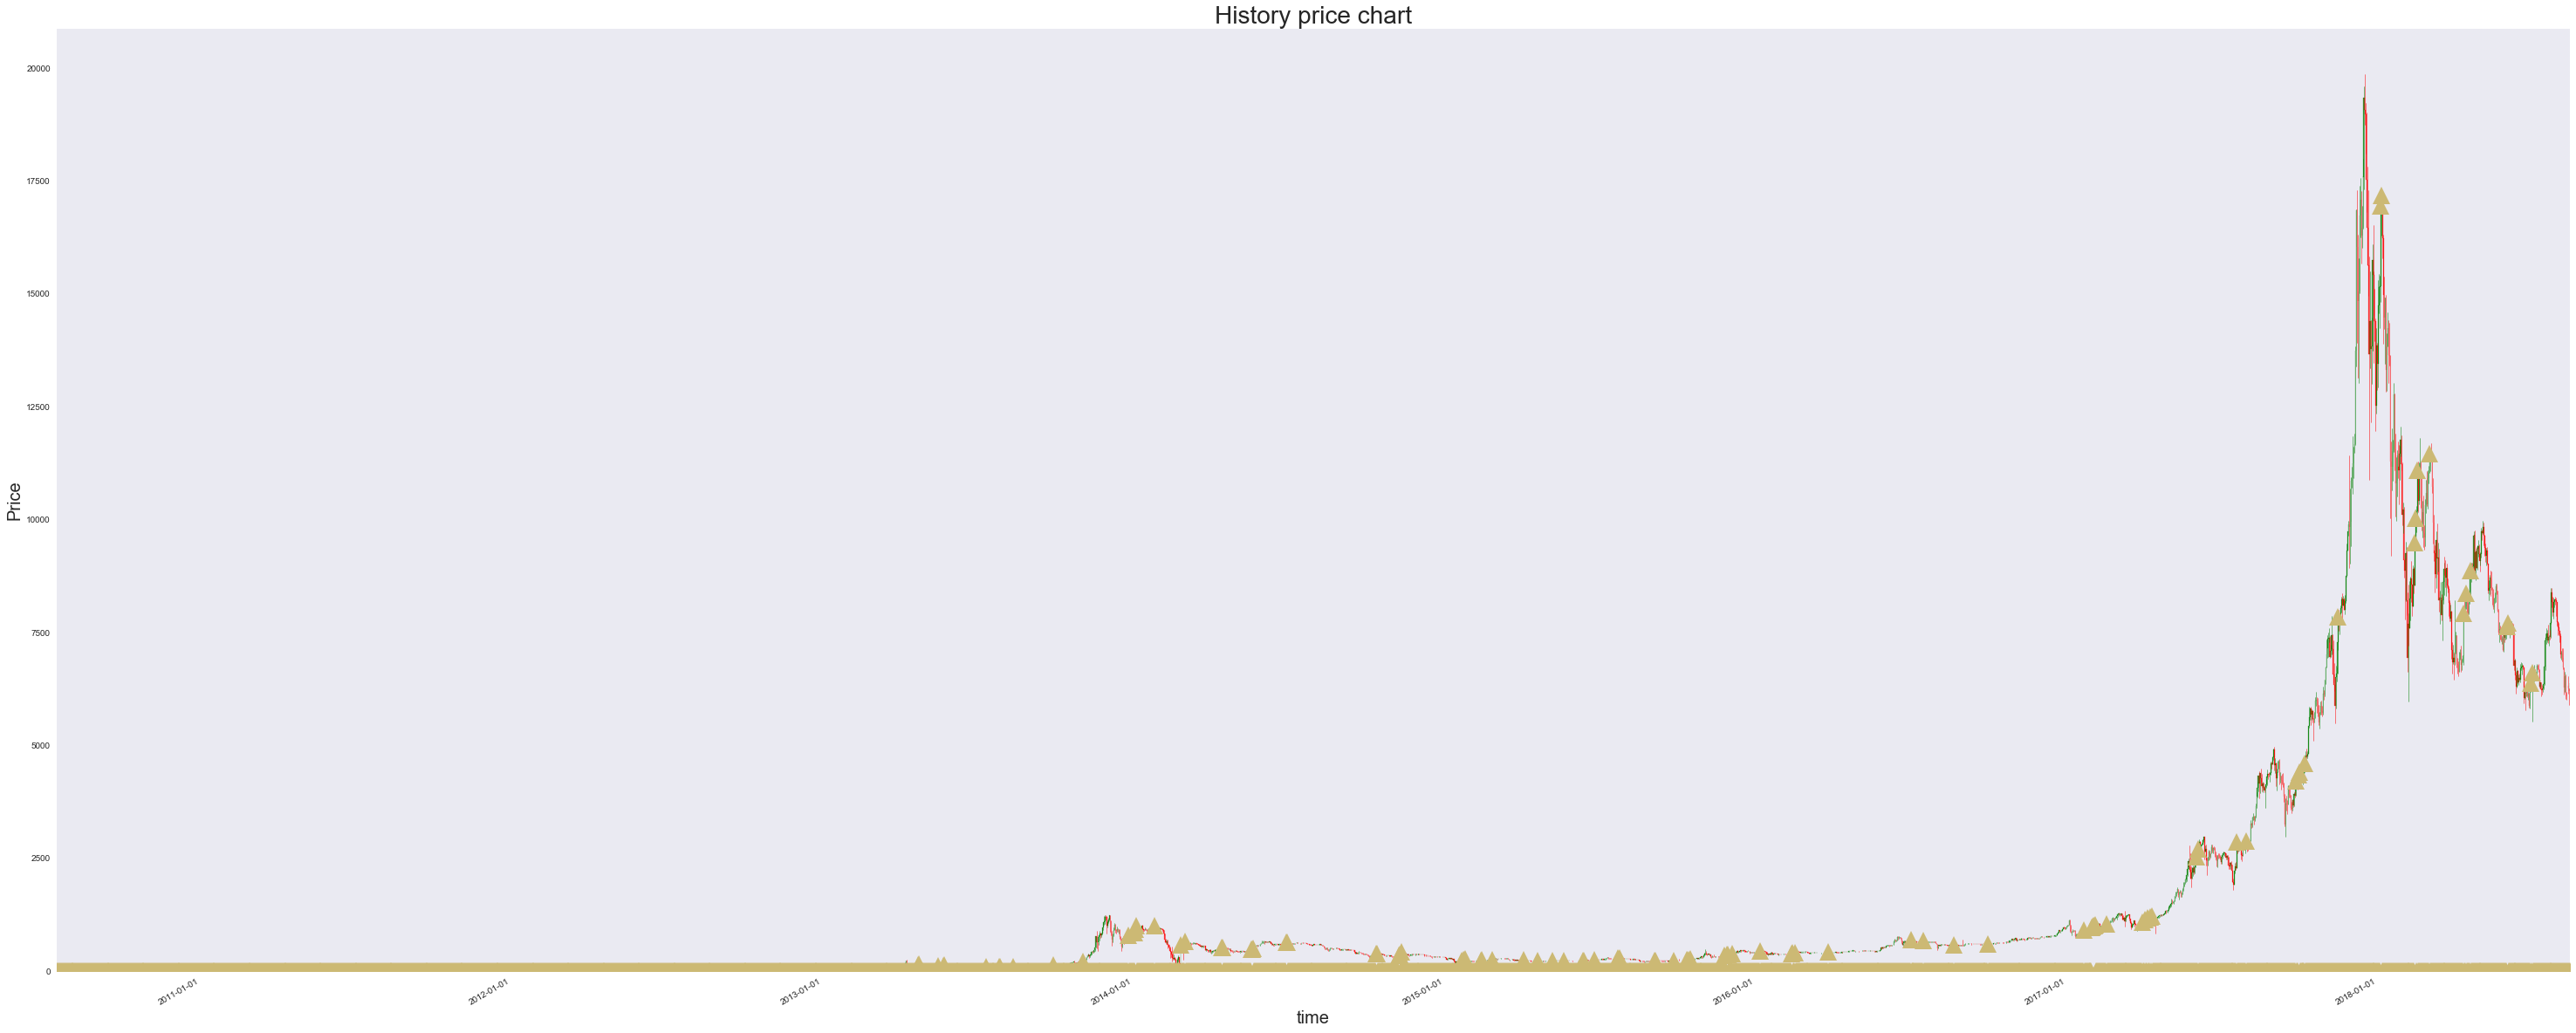

In [118]:
#data = tradeSRs(data)
plot_candlestick(data)

In [123]:
data.TradeExit.sum()

199989.51760000002

In [125]:
data, results = tradePerformance(data)

total number of trades: 115
number of winning trades: 90
number of losing trades: 25
winning trade pencentage: 78.26%
final balance: 188.15% (initial 100%)


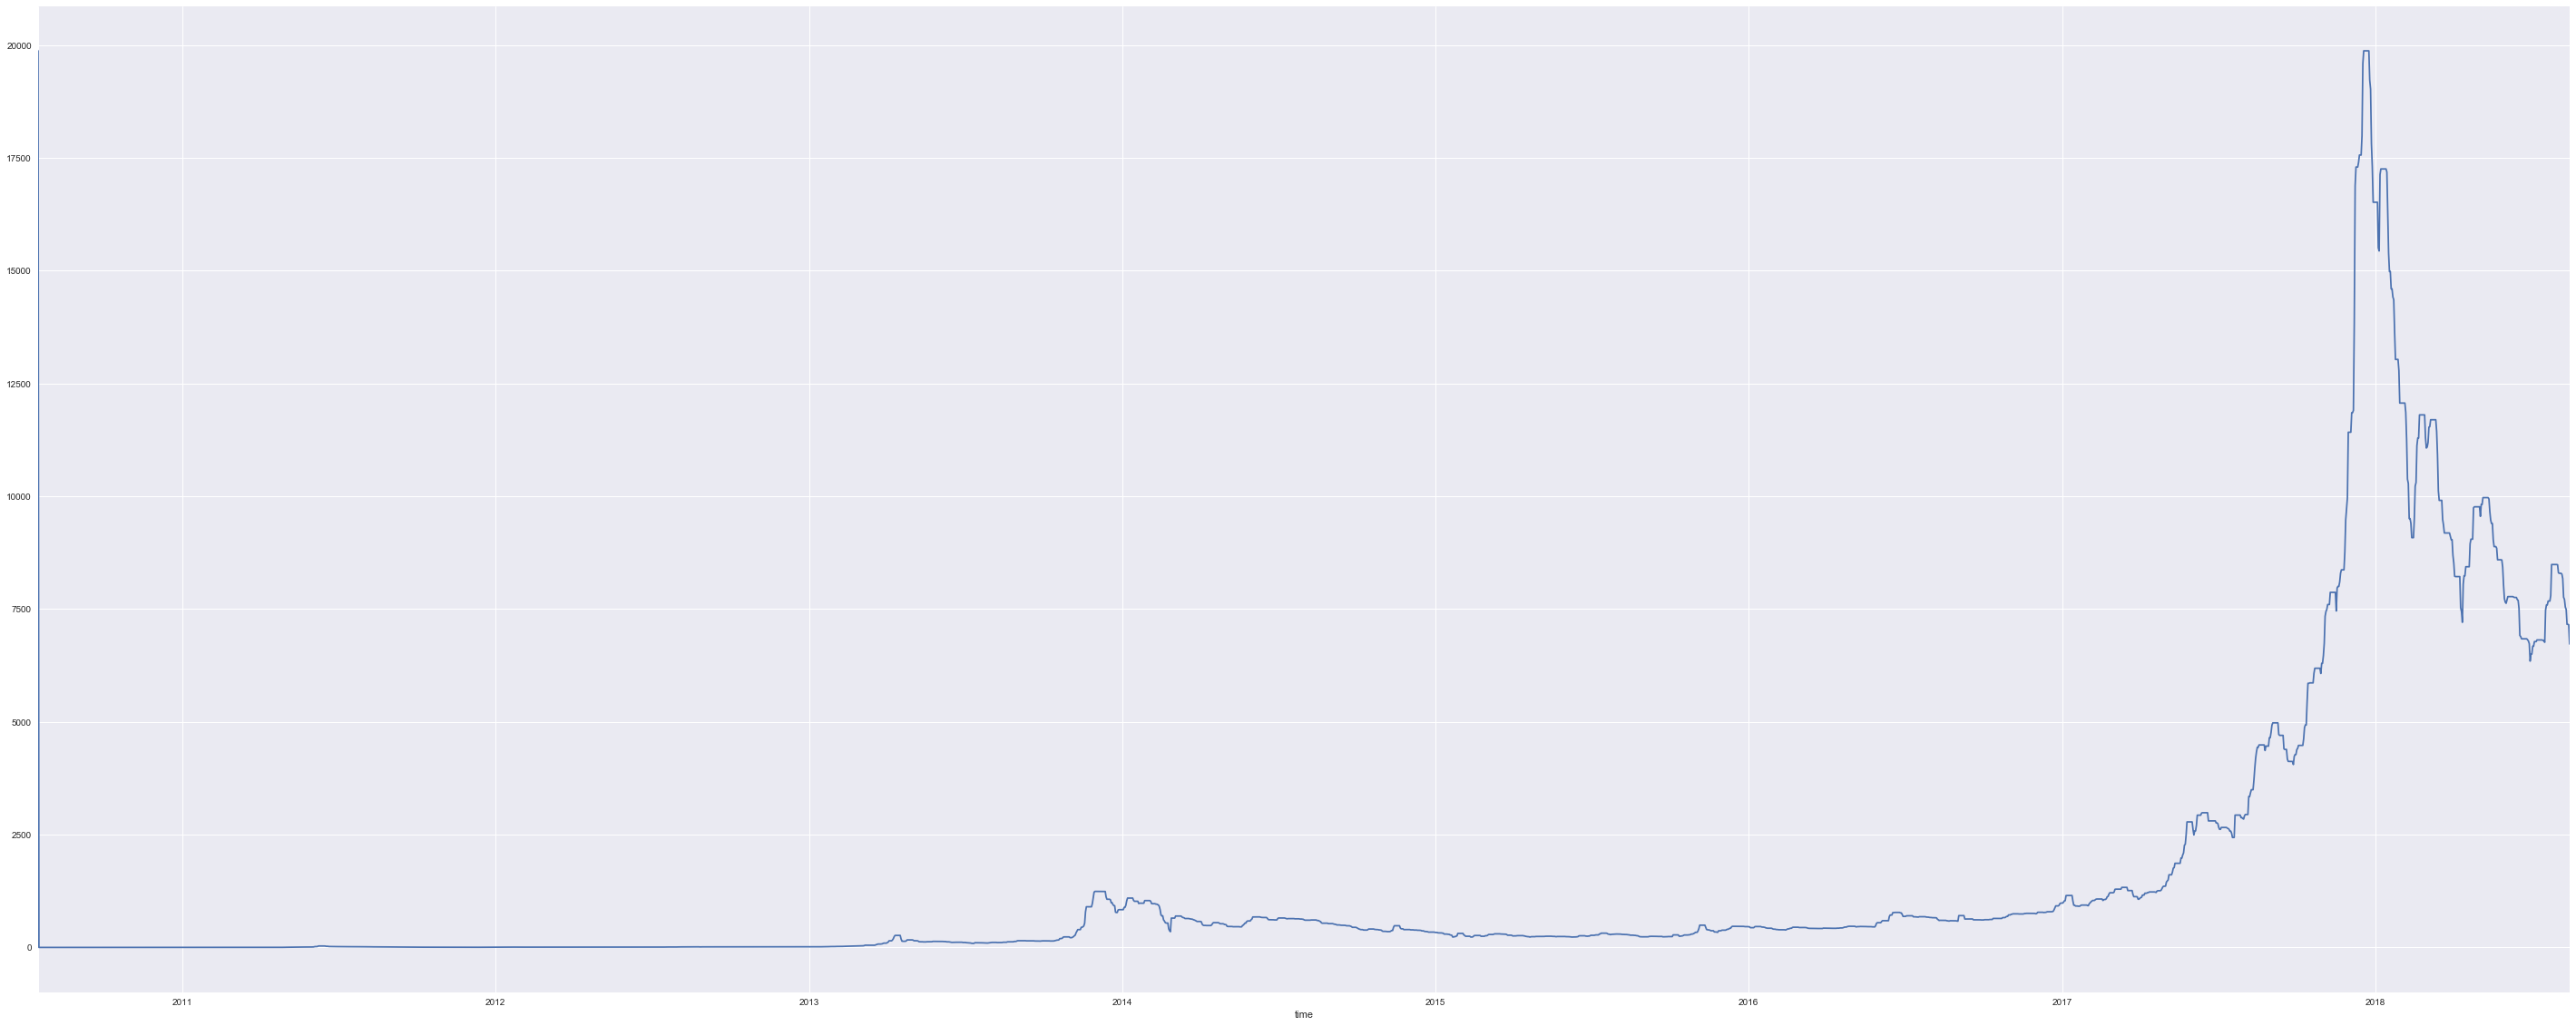

In [129]:
data.WeekResist.plot(linestyle='',marker="_", markeredgecolor ='red', markersize=20)